### 0. Import the packages

In [1]:
import os,sys,shutil,mmap
import pickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

import time
from sklearn.metrics import average_precision_score
import tensorflow as tf
import mir_eval

sys.path.insert(0,'lib/')
import config
import model_functions_norm2 as model_functions_norm # contains self-written functions

from versions_norm import version_dicc

%matplotlib inline


### 1. Pick the version

In [2]:
vers = "190322_LSTM_adam_pt_2"

for key, value in version_dicc[vers].items():
    print(f'{key:21}', ": ", value)

if "pt" in vers:
    PRETRAIN = True
    pretrain = version_dicc[vers]["pretrained"]
    print("\nUse pretrained weights")
else:
    PRETRAIN = False
#model_functions.test_import("Import successful.")
debugging = False

graph                 :  <function LSTM_PT_graph_AdamOpt_noReg at 0x7f6747b83950>
pretrained            :  190319_11HZ
window                :  4096
timesteps             :  9
stride                :  256
kk                    :  256
dd                    :  1024
d2_x                  :  1
d2_y                  :  128
k2                    :  128
stride_y              :  2
d3_x                  :  13
d3_y                  :  1
k3                    :  1024
num_units             :  1024
decay_steps           :  -1
lr_decay              :  -1
mom                   :  -1
starter_learning_rate :  0.001
beta1                 :  0.9
beta2                 :  0.999
max_steps             :  99999
comment               :  use pretrained weights, try more timesteps and bigger LSTM-Unit. Adam Optimizer

Use pretrained weights


### 2. Import the data
Import the recording and labels of the 331 recordings from the data base.

#### 2.1 Import the labels of the data set.
The 331 labels are saved in a dictionary whose
- keys are integers (the ids of the recordings)
- values are intervaltrees (for the different intervals of the recording it gives the played notes between 1 and 128)

In [3]:
with open(config.labels_path_11, 'rb') as f:
    labels = pickle.load(f)

#### 2.2 Import recordings

Create a dictionary containing the data (recordings). Use Memory-mapped file objects.
For each recording data[rec_id] is a tuple:
1. data[rec_id][0] is the memory-mapped file object to the recording. It can be accesed by 
~~~~~~
np.frombuffer(data[rec_id][0], dtype=np.float32).copy()
~~~~~~
2. data[rec_id][1] is its length (float)

In [4]:
data = dict()
for record in os.listdir(config.records_path_11_new):
    fd = os.open(config.records_path_11_new + record, os.O_RDONLY)
    buff = mmap.mmap(fd, 0, mmap.MAP_SHARED, mmap.PROT_READ)
    data[int(record[:-4])] = (buff, len(buff)/model_functions_norm.sz_float)
    os.close(fd)
    

#### 2.3 Split up in the test and train set

In [5]:
extended_test_set = True
use_mirex = True

# use the small or big test set
if extended_test_set:
    test_ids = config.test_ids_ext
else:
    test_ids = config.test_ids

# include the mirex dev set in test results
if use_mirex:
    test_ids = test_ids + config.mirex_id

train_ids = [rec_id for rec_id in labels.keys() if rec_id not in test_ids]

if debugging == True:
    train_ids = [rec_id for rec_id in train_ids if rec_id not in model_functions_norm.delete_ids]

print('There are {} samples in the test set'.format(len(test_ids)))
print('There are {} samples in the train set'.format(len(train_ids)))
    
#model_functions_norm.get_mean_std(train_ids, data)
    

There are 11 samples in the test set
There are 320 samples in the train set


#### 2.4 Calculate mean and Standard Deviation

The mean is approximatly 0 and standard deviation 1. Therefore, no normalization is applied.

In [6]:
#model_functions_norm.mean_std(data, train_ids)

### 3. Preprocessing

The input data (recordings) are normalized and the possible note range is defines to 128 notes. The lowest note is ..., the highest ... .

In [7]:
# Normalize the recordings
normalize = True
# Possible notes are from range [base_note, base_note + m)
base_note = 0
mm = 128

#### 3.1 Data augmentation

Always make two small changes to input data by randomly stretching or shrinking our input audio that are not noticable by human hearing, but augment the data set:
1. Pitch-shift in the frequency domain: Randomly  shifting  each data points in a minibatch by an integral number of semitones. This reinforces the architectural structure of the translation-invariant network.
2. Jittering: continuous shift to each data point. This makes the models more robust to tuning variation between recordings --> regularization

Define a function for extracting a sequence and its label as well as applying the data augmentation.

In [8]:
# pitching: stretching or shrinking our input audio with linear interpolation
pitch_transforms=5 # =/- 5 semitones
jitter=.1

Pitch-shifting corresponds to a multiplication by $2^{1/12}$ (an octave is equal to 12 semitones and corresponds to a factor 2 in the frequency domain) for each semirone.

A scaling factor in the frequency domain implies also a scaling factor in the time domain. (speeding up the recording $\to$ higher frequency $\to$ sounds higher.

All these methods are applied in the function 
~~~~~~
model_functions.get_data(rec_id, timesteps, s, window, pitch_shift, scaling_factor, normalize=True)
~~~~~~

#### 3.2 Batch-selection
Create the training batch applying the above explained methods for Data augmentation utilizing the function
~~~~~~
model_functions.get_training_batch(model_stats, batch_size, timesteps, window, pitch_transforms=0, jitter=0, normalize=True)
~~~~~~

#### 3.3 Creation of Training and Test set for protocolling

Routines that create sample for the protcoling:
1. Routine to obtain the training samples given the recording IDs of the training samples.
   -> If sample with same settings already got created and was saved to file it is loaded from numpy.
   -> Else: create the sample by taking at most 100 samples for each recording. Save it to file.
   
  ~~~~~~
  model_functions.get_training_sample(rec_ids, timesteps, d=16384, normalize=True)
  ~~~~~~
   
2. Routine to obtain test samples given the recording IDs of the test samples.
   -> If sample with same settings already got created and was saved to file it is loaded from numpy.
   -> Else: create the sample by taking at most 1000 samples for each recording. Save it to file.
   ~~~~~~
   model_functions.get_test_sample(rec_ids, window, count, timesteps, fixed_stride=-1, pitch_shift=0, normalize=True)
   ~~~~~~
   
### 4. Prepare Protocolling
Save the results, losses, precicions and weights at each protocol point in a diccionary, that is created and updated using the class 
~~~~~~
model_results
~~~~~~

### 5. Error measures
Define the error measures for comparing the correct labeling Y with the extimated labeling Y_hat.
Both labelings are of size (mm) for each segment. The errors are calculated at each protocol point for the training and the test set.
1. Mean Squared Error: When applying the model to a sequence or sequences the mean squared error is calculated directly by applying the tensorflow function.
~~~~~~~~~~~~~~~~~~~~~
tf.reduce_mean(tf.nn.l2_loss( Y_hat - Y ))
~~~~~~~~~~~~~~~~~~~~~
2. Average Precision: The average precision is calculated with the metric function from the sklear package.
~~~~~~~~~~~~~~~~~~~~~
sklearn.metrics.average_precision_score
~~~~~~~~~~~~~~~~~~~~~

### 6. Define the graph

Define batch size (batch_size segments at each training step). Also define a small factor wscale to scale the weights. Regularization can be avoided.

In [9]:
batch_size=150
if debugging == True:
    batch_size = 2
out = 1

#### 6.1 Define layers

#### First layer: 

Lenth of the input (segment) is window=16384. Compute a strided convolution with a d=4096-sample recptive field and a stride=512 sample stride. Since every segment has 16384 samples there are 25 regions for each frame.

After the convolution for each region a filterbank computation is calculated. 
As a filter a log-spaced filterbank is chosen (k=512 sine and cosine filters with logarithmically spaced frequencies from 50 hz to 6000 hz) which is going to be applied to all the regions of the convolution of size d=4096.
The filterbank is created by 
~~~~~~
model_functions.create_filters(d,k)
~~~~~~

#### Second layer:
A convolution is applied along the log-frequency axis opening up a third channel dimension.

#### Third layer:
Convolution along the log-frequency axis. Filters of height 1 are used that fully connect along the time and channel axes of Layer 2

In [10]:
##### variables for input layer

# input size of segment, predict notes played at midpoint of segment
window = version_dicc[vers]["window"]

# number of timesteps to be considered for memory cell
timesteps = version_dicc[vers]["timesteps"]

# size of regions that outputs the convolution from layer one (receptive field)
dd = version_dicc[vers]["dd"]

#stride for first layer convolution --> 13 regions
stride = version_dicc[vers]["stride"]

# variables for filterbank (= first layer)
# number of nodes in first layer (by filterbank get from dd nodes to kk nodes)
kk = version_dicc[vers]["kk"]
wsin,wcos = model_functions_norm.create_filters(dd,kk)

##### variables for second layer
d2_x = version_dicc[vers]["d2_x"]           # lvl2 input dims_x
d2_y = version_dicc[vers]["d2_y"]           # lvl2 input dims_y
k2 = version_dicc[vers]["k2"]               # num lvl2 filters
stride_y = version_dicc[vers]["stride_y"]   # lvl2 stride

##### variables for third layer
d3_x = version_dicc[vers]["d3_x"]           # lvl3 input dims_x
d3_y = version_dicc[vers]["d3_y"]           # lvl3 input dims_y (fully connected)
k3 = version_dicc[vers]["k3"]               # num lvl3 filters

#### variables for LSTM-cell
num_units = version_dicc[vers]["num_units"]

Calculate the sizes of nodes at each layer and the first layer filterbank.

In [11]:
num_regions, num_regions2_x, num_regions2_y, num_regions3_x, num_regions3_y = \
model_functions_norm.calc_region_sizes(window, dd, stride, kk, d2_x, d2_y, stride_y, d3_x, d3_y)

First layer regions: (13,256)
Second layer regions: (13,65)
Third layer regions: (1,65)


#### 6.2 Define tf.Graph()
Set it all together and define the graph.

Define:
- the starter leraning rate
- learning rate decay
- number of steps after which learning rate decay is applied
- the L2-regularization weight
- the Momentum for the tf.train.MomentumOptimizer

For evaluation not the trained weights, but its moving averages with decay 0.9998 are utilized. The shadow variables are maintained by tf.train.ExponentialMovingAverage. In the block for evaluating the direct model their values are retrieved.

In [12]:
# initialize diccionary to save results
model_stats = model_functions_norm.model_results(test_ids, train_ids, labels, data, base_note, mm)

tf.set_random_seed(999)

starter_learning_rate = version_dicc[vers]["starter_learning_rate"]  # starter leraning rate
decay_steps = version_dicc[vers]["decay_steps"]                      # steps until learning rate decay
lr_decay = version_dicc[vers]["lr_decay"]                            # learning rate decay
mom = version_dicc[vers]["mom"]                                      # Momentum for Optimizer
beta_reg = 0                                                         # L2-regularization weight


if PRETRAIN:
    graph, training_op, loss, global_step,lr,reg,y_pd,direct_loss,xb,yb,xd,yd,saver,w,wavg,w2,w2avg,beta,betaavg = \
                                    version_dicc[vers]["graph"] (
                                                model_stats, batch_size, window, timesteps, 
                                                stride, out, wsin, wcos, 
                                                d2_x, d2_y, k2, stride_y, 
                                                d3_x, d3_y, k3, num_regions3_x, num_regions3_y, num_units,
                                                starter_learning_rate, decay_steps, lr_decay)
else:   
    graph, training_op, loss, global_step, lr, reg, y_pd, direct_loss, xb, yb, xd, yd, saver = \
                                    version_dicc[vers]["graph"] (
                                                model_stats, batch_size, window, timesteps, 
                                                stride, out, wsin, wcos, 
                                                d2_x, d2_y, k2, stride_y, 
                                                d3_x, d3_y, k3, num_regions3_x, num_regions3_y, num_units,
                                                starter_learning_rate, decay_steps, lr_decay)


---- Weights ----
w <tf.Variable 'parameters/w:0' shape=(1, 128, 1, 128) dtype=float32_ref>
w2 <tf.Variable 'parameters/w2:0' shape=(13, 1, 128, 1024) dtype=float32_ref>
beta <tf.Variable 'parameters/beta:0' shape=(66560, 128) dtype=float32_ref>
w_proj <tf.Variable 'parameters_train/w_proj:0' shape=(2048, 128) dtype=float32_ref>

---- Layers ----
zx Tensor("model/add:0", shape=(?, 1, 13, 256), dtype=float32)
z2 Tensor("model/Relu:0", shape=(?, 128, 13, 65), dtype=float32)
z3 Tensor("model/Relu_1:0", shape=(?, 1024, 1, 65), dtype=float32)
y_feed_forward Tensor("model/MatMul:0", shape=(1350, 128), dtype=float32)

---- LSTM-Cell ----
Number of units: 1024
Shape of input: (150, 9, 128)
Shape of output: 2 x (150, 1024)
y_output: Tensor("model/MatMul_1:0", shape=(150, 128), dtype=float32)


#### 6.3 Evaluation of the graph

For the aplication of the neuronal network a moving average of the weights is used. Therefore, a different function for evaluation is used.

Inside the function 
~~~~~~
model_functions.predict_direct_model(sess, X, Y) 
~~~~~~
the mean squared error is calculated directly.

### 7. Training

In [13]:
print(vers)
results_stats = model_functions_norm.load_obj('results/'+vers+'_stats')
iters_res = results_stats['iter'][2]
mse_test_res = results_stats['mse_test'][2]
avp_test_res = results_stats['avp_test'][2]
mse_train_res = results_stats['mse_train'][2]
avp_train_res = results_stats['avp_train'][2]
time_res = results_stats['time'][2]
print ('iter\t test_squ_loss\t test_avg_prec\t train_squ_loss\t train_avg_prec\t time (in s)')
for i in range(len(iters_res)):
    print (iters_res[i],'\t', round(mse_test_res[i],8),
            '\t', round(avp_test_res[i],8),
            '\t', round(mse_train_res[i],8),
            '\t', round(avp_train_res[i],8),
            '\t', round(time_res[i],8))

190322_LSTM_adam_pt_2
iter	 test_squ_loss	 test_avg_prec	 train_squ_loss	 train_avg_prec	 time (in s)
1 	 15.06593312 	 0.04364124 	 334.9203965 	 5.891e-05 	 124.29121852
1001 	 10.50626939 	 0.48885641 	 0.42479296 	 0.55875285 	 378.84675336
2001 	 10.16240281 	 0.5255025 	 0.26481599 	 0.57241801 	 359.27101755
3001 	 9.69871205 	 0.53850706 	 0.25562882 	 0.57226647 	 358.23579001
4001 	 9.28599909 	 0.55160845 	 0.97450787 	 0.58789269 	 361.26115727
5001 	 8.95101354 	 0.55831766 	 1.7137483 	 0.58955119 	 353.13246393
6001 	 8.54414339 	 0.57037779 	 1.37697656 	 0.58710632 	 352.92531776
7001 	 8.24267478 	 0.57658788 	 1.12207203 	 0.60612359 	 352.46146607
8001 	 8.09781784 	 0.58327455 	 0.94608789 	 0.59198414 	 354.65601635
9001 	 7.9764964 	 0.58673148 	 0.85908725 	 0.59383595 	 352.93279362
10001 	 7.89054579 	 0.58734118 	 0.62846077 	 0.60381686 	 350.88658214
11001 	 7.81480282 	 0.58934846 	 0.55044445 	 0.62202916 	 353.21442103
12001 	 7.67790862 	 0.59950454 	 0

### 8. Post Processing
#### 8.1 Plots

Plot leraning rate, possibly runtime, errors, precision and norms

In [14]:
results_stats = model_functions_norm.load_obj('results/'+vers+'_stats')

# size of plots
plot_characteristics = {'width': 20, 'height': 13, 'fontsize': 24, 'control_step': 1000, 'savefig': False}

plt.rcParams['xtick.labelsize']=plot_characteristics['fontsize']
plt.rcParams['ytick.labelsize']=plot_characteristics['fontsize']

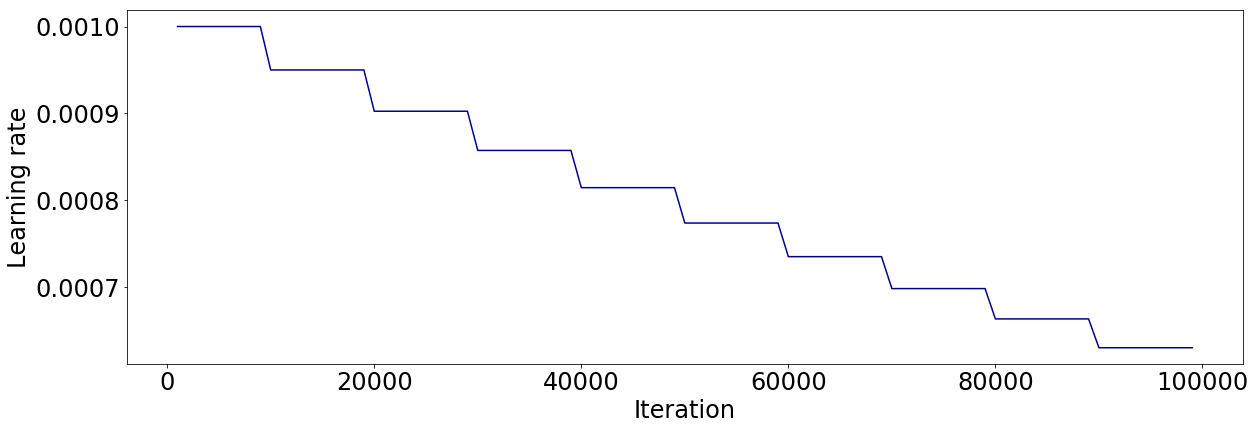

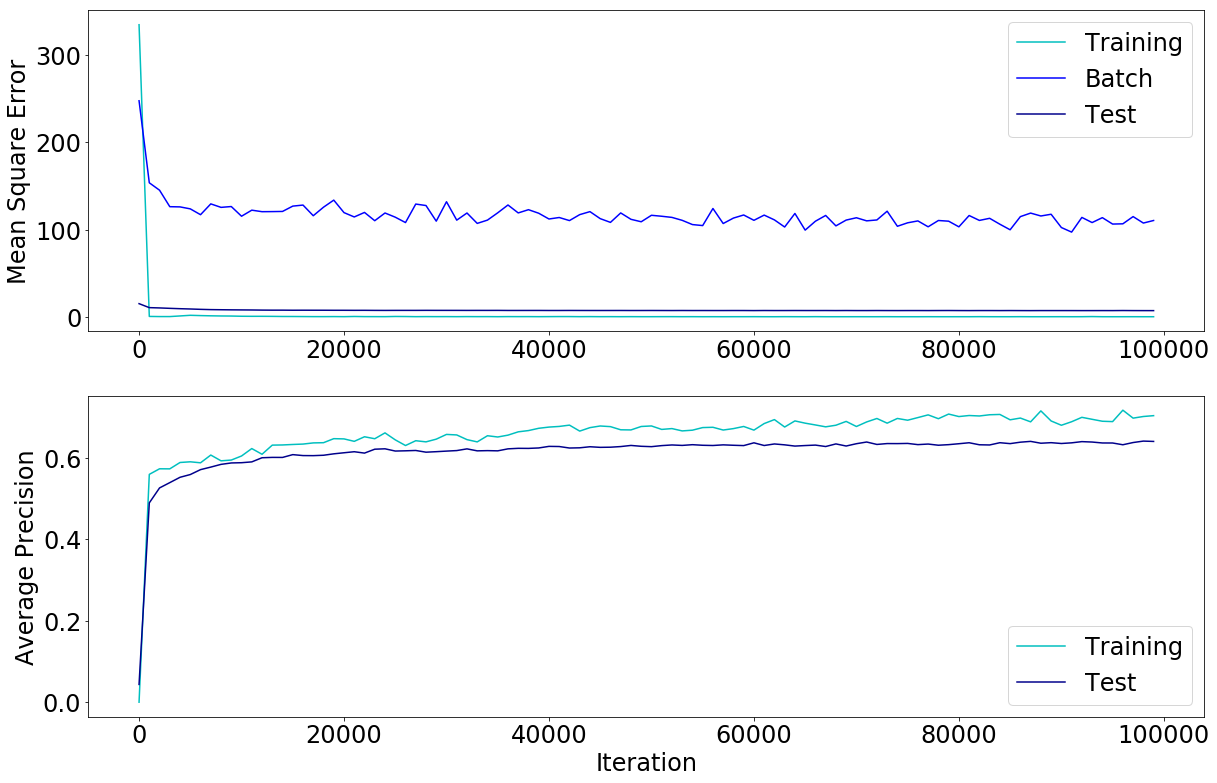

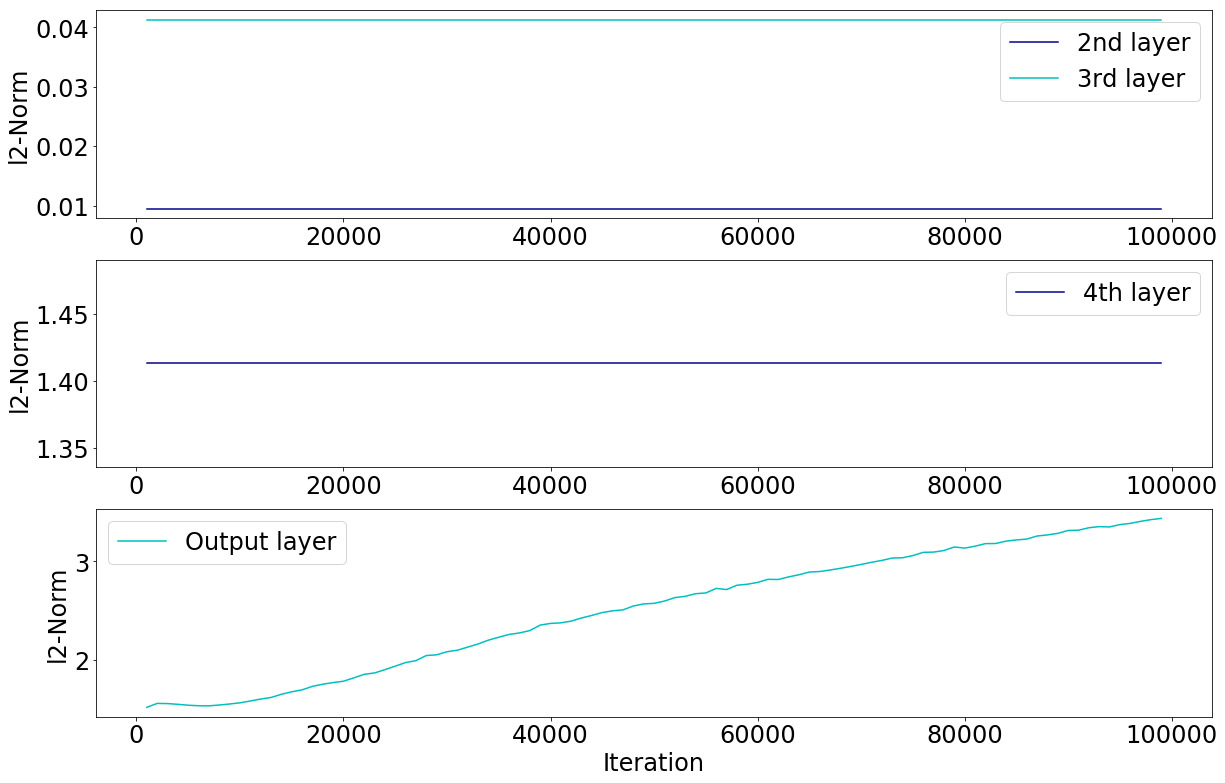

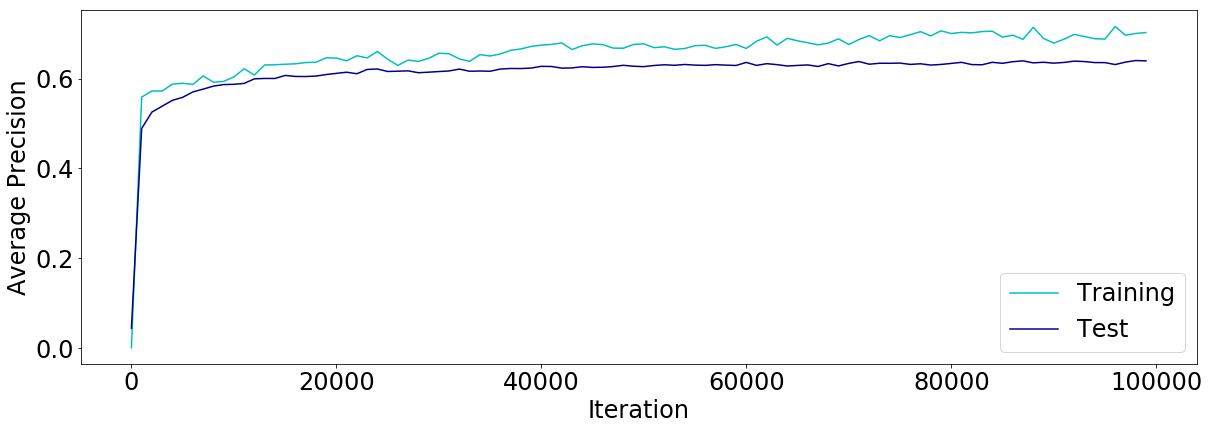

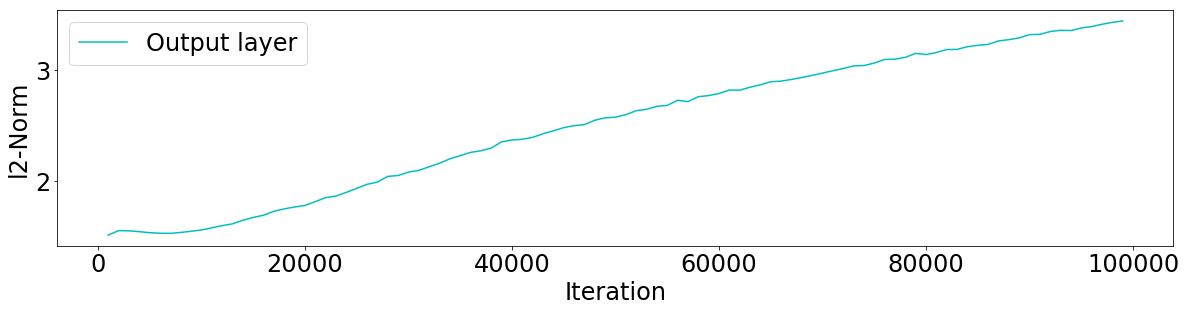

In [15]:
################################################################
# learning rate
model_functions_norm.plot_lr(results_stats, plot_characteristics, vers)

################################################################
# error and precision
model_functions_norm.plot_err_prec(results_stats, plot_characteristics, vers)

################################################################
# norms of the weights
if "LSTM" not in vers:
    model_functions_norm.plot_norms(results_stats, plot_characteristics, vers)
else:
    model_functions_norm.plot_norms_lstm(results_stats, plot_characteristics, vers)
    
################################################################
# save only precision and plot of norm output layer
#plot_characteristics['savefig'] = True
model_functions_norm.plot_prec(results_stats, plot_characteristics, vers)
if "LSTM" in vers:
    model_functions_norm.plot_out_norms(results_stats, plot_characteristics, vers)

#### 8.2 Mirex Statistics

Statistics that are necesarry for evaluation. The autuor used a threshold of 0.4 for calculation of error etc...

First, restore the model and calculate the output to the test sample:

In [16]:
tf.reset_default_graph()

num_steps = version_dicc[vers]["max_steps"]
timesteps = version_dicc[vers]["timesteps"]

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session(graph=graph) as sess:
    # Restore variables from disk.
    saver.restore(sess, 'models/model_'+vers+'/model-'+str(num_steps))
    print("Model restored.")

    # 1. get the test set
    X, Y = model_functions_norm.get_test_sample(model_stats, timesteps, window, 1000)
    Y = Y[:,base_note:base_note+mm] # in general without effect
    # shape Xtest: (1000*len(test_ids), 1, window, 1)
    # shape Ytest: (1000*len(test_ids), 128)
    # extended test-set: 11 samples

    # 2. prediction of output
    Y_p, mse_test = model_functions_norm.predict_direct_model(sess, y_pd, direct_loss, xd, yd, X, Y)


INFO:tensorflow:Restoring parameters from models/model_190322_LSTM_adam_pt_2/model-99999
Model restored.


With the output of the test sample predicted calculate the mirex statistics:

Average Precision (not from mireval), Precision, Recall, Accuracy, Total Error, Substitution, Miss, False Alarm

In [35]:
print('Thr\tAvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
for th in [.3, .35,.4, .45, .5]:
    #print("When using threshold",th)
    avp,P,R,Acc,Etot = model_functions_norm.mirex_statistics(Y, Y_p, th)

Thr	AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
0.30	57.235	51.866	62.311	0.395	0.731	0.224	0.153	0.354
0.35	57.235	56.044	57.102	0.394	0.673	0.204	0.225	0.244
0.40	57.235	59.906	51.657	0.384	0.655	0.175	0.309	0.171
0.45	57.235	63.586	45.836	0.363	0.658	0.146	0.395	0.116
0.50	57.235	66.944	39.933	0.334	0.681	0.117	0.484	0.080


INFO:tensorflow:Restoring parameters from models/model_190322_LSTM_adam_pt_2/model-99999
Model restored.


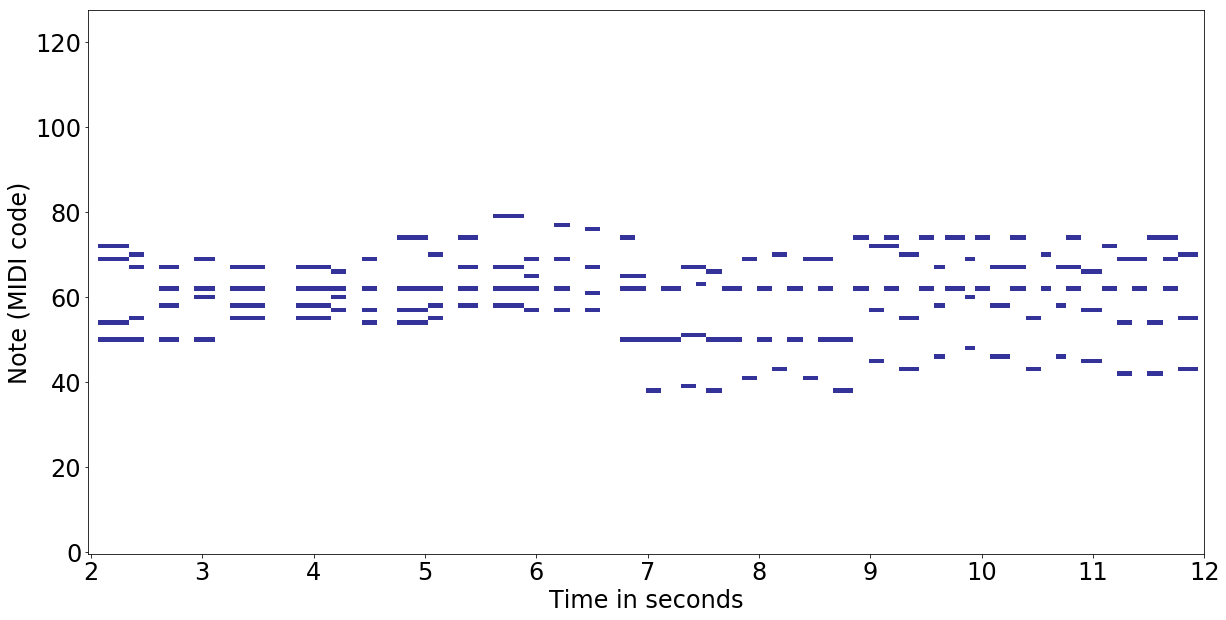

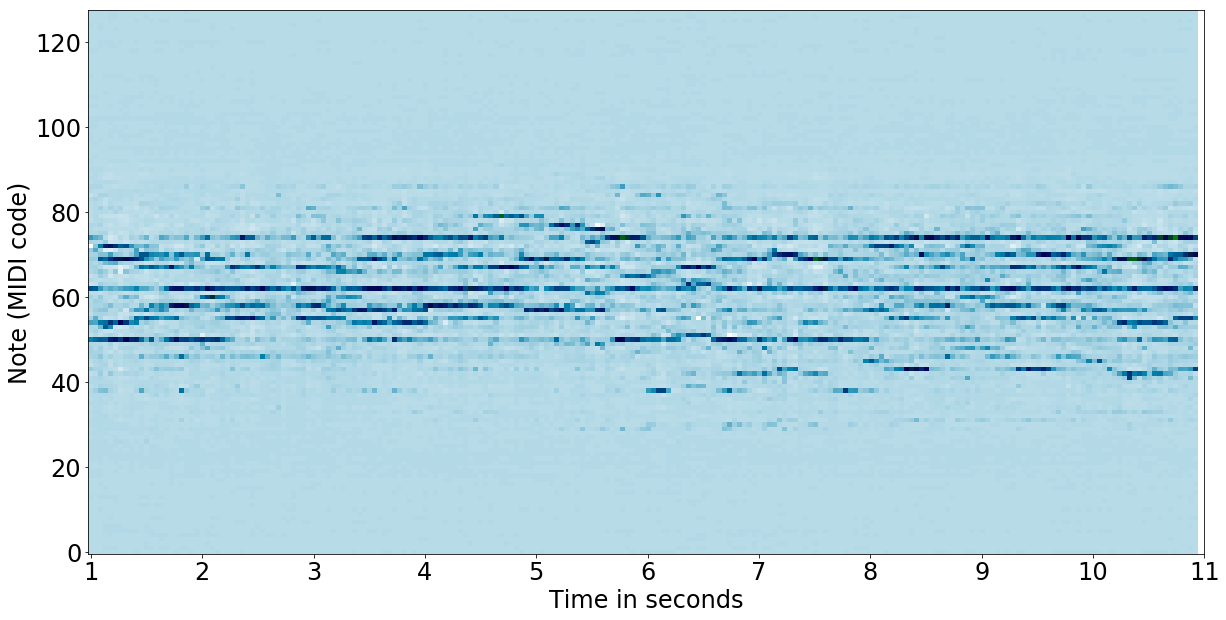

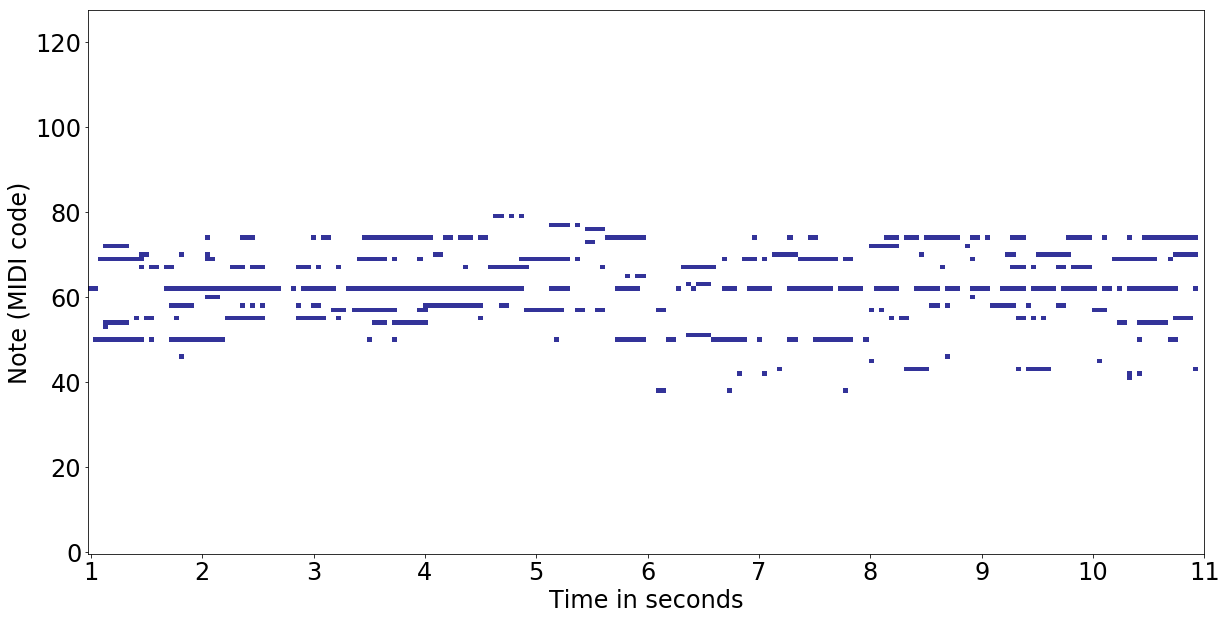

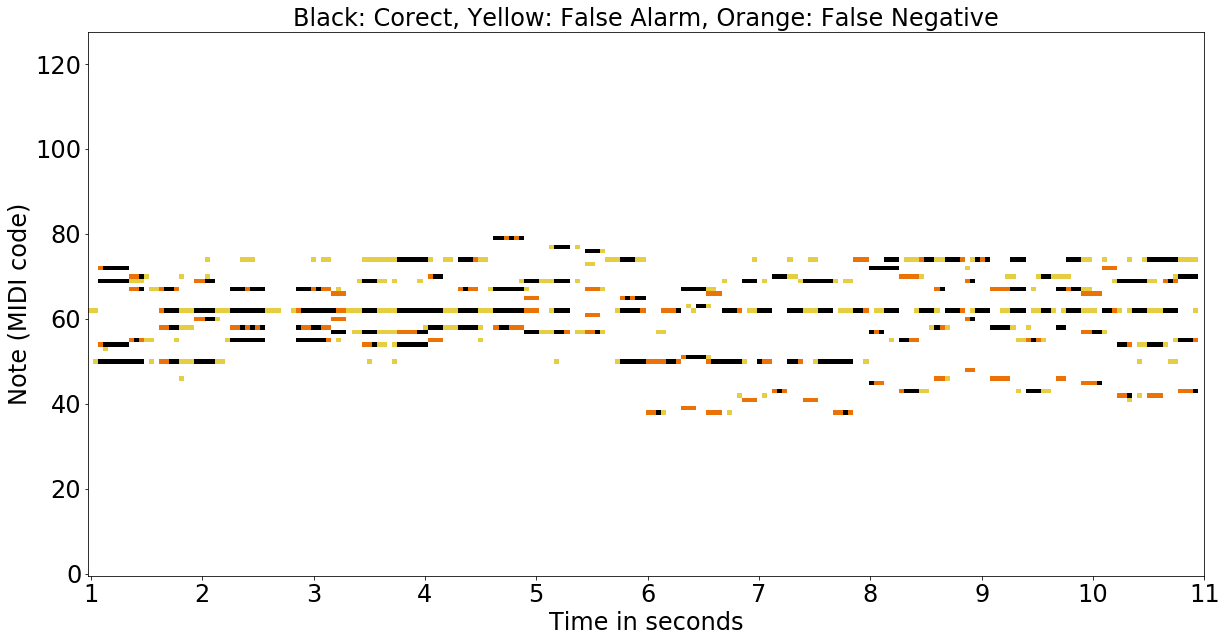

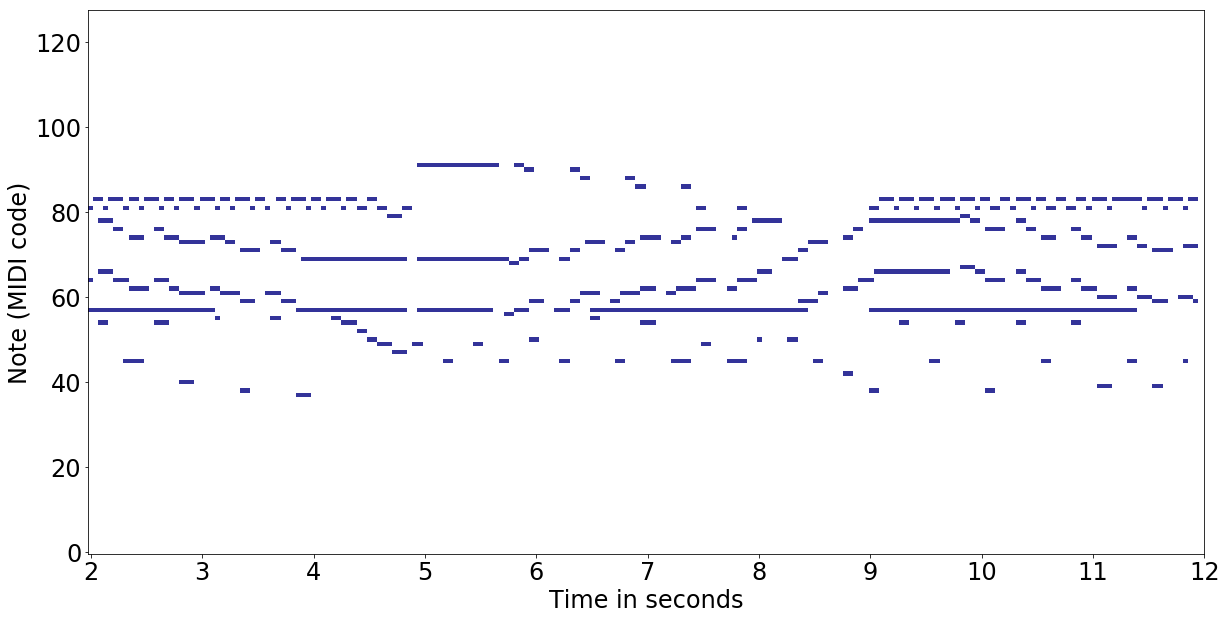

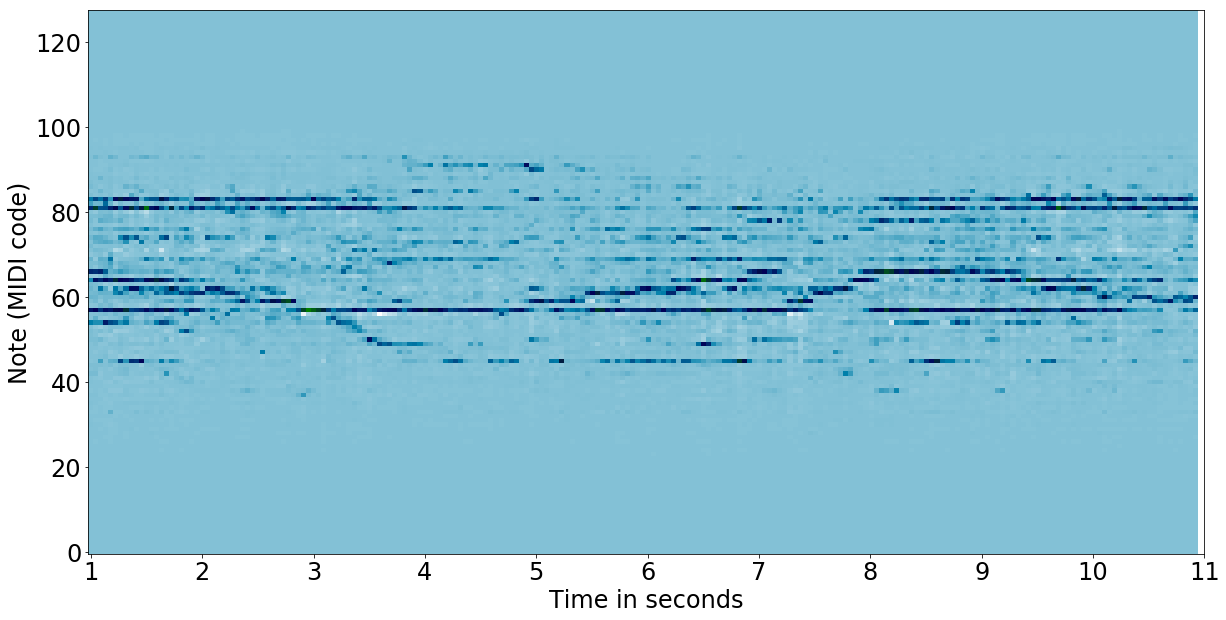

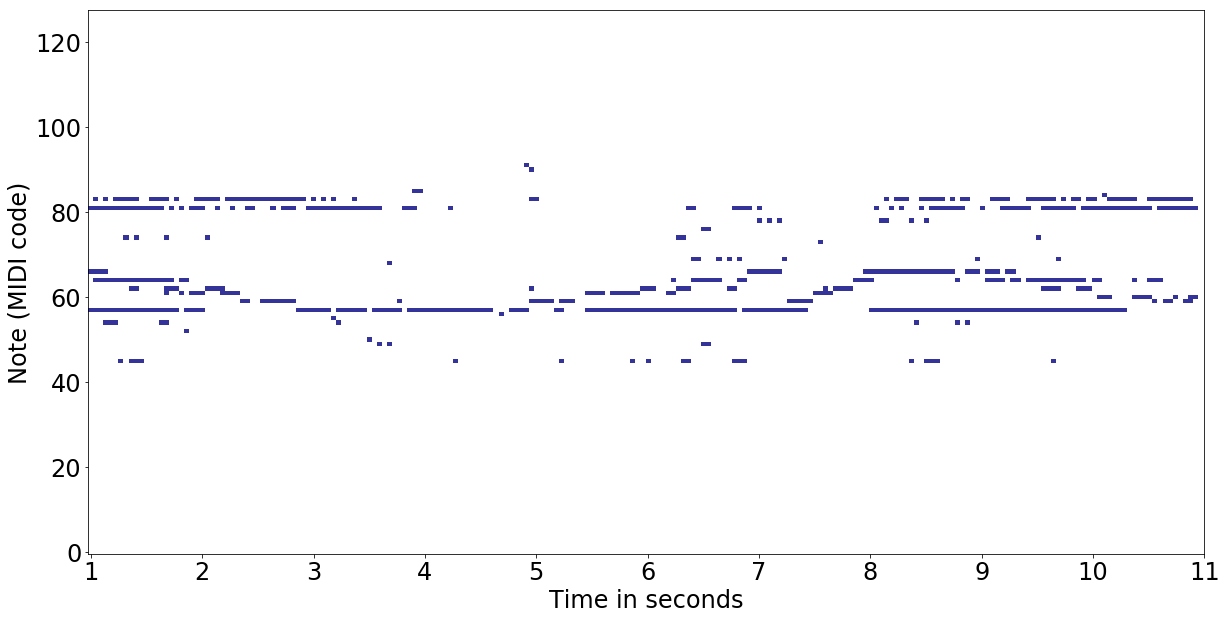

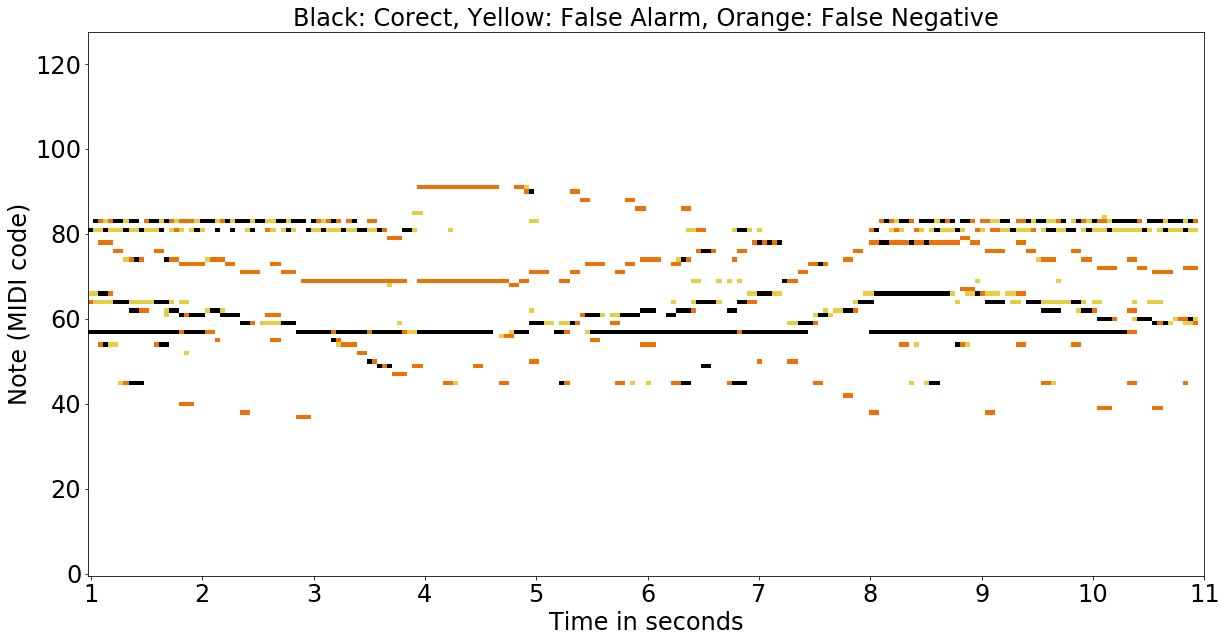

In [19]:
# 2191 sehr einfach
# 2628 einfach
# 2718 schwierig

sample_test_ids = [2628,2718] 
#sample_test_ids = [2382, 1819, 2298, 2191, 2556, 2416, 2628, 1759, 2106, 2718]
tf.reset_default_graph()
with tf.Session(graph=graph) as sess:
    num_steps = version_dicc[vers]["max_steps"]
    timesteps = version_dicc[vers]["timesteps"]
    # Restore variables from disk.
    saver.restore(sess, 'models/model_'+vers+'/model-'+str(num_steps))
    print("Model restored.")
    for i in range(len(sample_test_ids)):
        sample_test_id = sample_test_ids[i]

        lenn = data[sample_test_id][1]
        y_sample = labels[sample_test_id]
        times, check = model_functions_norm.scores(y_sample, sample_test_id, start=2)

        # 1. get the set
        X, Y = model_functions_norm.get_times(model_stats, sample_test_id,times,timesteps,window)
        Y = Y[:,base_note:base_note+mm] # in general without effect

        # 2. prediction of output
        Y_p, mse_test = model_functions_norm.predict_direct_model(sess, y_pd, direct_loss, xd, yd, X, Y)

        _ = model_functions_norm.scores(Y_p, str(sample_test_id)+': prediction', 
                                        start=1,downsample=False,cmap='ocean_r') 
        _ = model_functions_norm.scores(Y_p>0.4, str(sample_test_id)+': prediction, 0.4 threshold applied', start=1,downsample=False) 
        _ = model_functions_norm.compare_scores(check, 1*(Y_p>0.4), sample_test_id, cmap='CMRmap_r',
                    savefig='results/plots/'+vers+'_score_rec_'+str(sample_test_id)+'_compare.png')
    

